# Temporal & Geographic Analysis - Publication Figures

**Purpose**: Generate publication-ready figures for:
- **Section 2.3**: Micro-Temporal Burst Detection (OPTIONAL)
- **Section 2.4**: Sender Behavioral Patterns (H3 VALIDATION)

---
## Notebook Structure:
1. Setup & Data Loading
2. Section 2.3: Micro-Temporal Burst Analysis
3. Section 2.4: Sender Behavioral Patterns
4. Hypothesis H3 Summary Tables
5. Cross-Validation Tests

---

## 1. Setup & Data Loading

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plotting configuration for publication quality
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Libraries loaded successfully")
print(f"📊 Matplotlib version: {plt.matplotlib.__version__}")
print(f"📊 Seaborn version: {sns.__version__}")

✅ Libraries loaded successfully
📊 Matplotlib version: 3.10.7
📊 Seaborn version: 0.13.2


In [4]:
# Load your processed data
# MODIFY THIS PATH to your actual data file
df = pd.read_csv('cleaned_date_merged_data.csv', parse_dates=['date'])

# Verify data structure
print("="*80)
print("DATA LOADED")
print("="*80)
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"\n📋 Columns: {df.columns.tolist()}")
print(f"\n🏷️ Label Distribution:")
print(df['label'].value_counts())
print(f"\n📈 Phishing Rate: {df['label'].mean()*100:.2f}%")
print(f"\n📅 Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"📆 Days Covered: {(df['date'].max() - df['date'].min()).days + 1} days")

# Quick data validation
assert 'sender' in df.columns, "❌ Missing 'sender' column"
assert 'date' in df.columns, "❌ Missing 'date' column"
assert 'label' in df.columns, "❌ Missing 'label' column"
print("\n✅ Data validation passed!")

DATA LOADED

📊 Dataset Shape: (48803, 16)

📋 Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls', 'timezone_hours', 'timezone_region', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_name', 'is_weekend']

🏷️ Label Distribution:
label
1    27406
0    21397
Name: count, dtype: int64

📈 Phishing Rate: 56.16%

📅 Date Range: 1990-01-01 17:57:46 to 2022-12-27 10:56:49
📆 Days Covered: 12048 days

✅ Data validation passed!


---
## 2. Section 2.3: Micro-Temporal Burst Detection (OPTIONAL)

**Hypothesis**: Legitimate senders exhibit higher burst rates due to mailing lists, while phishers use single-use accounts.

**Key Metrics**:
- Max emails per hour by sender
- Burst sender classification (>1 email/hour)
- Distribution comparison

---

In [5]:
# Calculate max emails per hour for each sender
print("⏳ Calculating max emails per hour for each sender...")

max_emails_per_hour = df.groupby('sender').apply(
    lambda x: x.set_index('date').resample('1H').size().max()
).reset_index()
max_emails_per_hour.columns = ['sender', 'max_emails_per_hour']

# Get sender labels (phisher vs normal)
sender_labels = df.groupby('sender')['label'].agg(['mean', 'sum', 'count']).reset_index()
sender_labels.columns = ['sender', 'phishing_rate', 'phishing_count', 'total_emails']
sender_labels['sender_type'] = sender_labels['phishing_rate'].apply(
    lambda x: 'Phishing' if x > 0.5 else 'Legitimate'
)

# Merge
max_emails_per_hour = max_emails_per_hour.merge(
    sender_labels[['sender', 'sender_type', 'phishing_rate']], 
    on='sender'
)

# Separate by type
legitimate_max = max_emails_per_hour[max_emails_per_hour['sender_type'] == 'Legitimate']['max_emails_per_hour']
phishing_max = max_emails_per_hour[max_emails_per_hour['sender_type'] == 'Phishing']['max_emails_per_hour']

print(f"✅ Calculation complete!")
print(f"\n📊 Legitimate Senders: {len(legitimate_max):,}")
print(f"📊 Phishing Senders: {len(phishing_max):,}")

⏳ Calculating max emails per hour for each sender...
✅ Calculation complete!

📊 Legitimate Senders: 4,738
📊 Phishing Senders: 26,018


In [6]:
# Statistical Summary
print("="*80)
print("MAX EMAILS PER HOUR - STATISTICAL SUMMARY")
print("="*80)

stats_df = pd.DataFrame({
    'Metric': ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', '% ≤1 email/hour'],
    'Legitimate': [
        f"{len(legitimate_max):,}",
        f"{legitimate_max.mean():.2f}",
        f"{legitimate_max.median():.2f}",
        f"{legitimate_max.std():.2f}",
        f"{legitimate_max.min():.0f}",
        f"{legitimate_max.max():.0f}",
        f"{(legitimate_max <= 1).mean()*100:.1f}%"
    ],
    'Phishing': [
        f"{len(phishing_max):,}",
        f"{phishing_max.mean():.2f}",
        f"{phishing_max.median():.2f}",
        f"{phishing_max.std():.2f}",
        f"{phishing_max.min():.0f}",
        f"{phishing_max.max():.0f}",
        f"{(phishing_max <= 1).mean()*100:.1f}%"
    ]
})

print(stats_df.to_string(index=False))

# Statistical test
statistic, pvalue = stats.mannwhitneyu(legitimate_max, phishing_max, alternative='two-sided')
print(f"\n📊 Mann-Whitney U Test:")
print(f"   Statistic: {statistic:,.2f}")
print(f"   P-value: {pvalue:.4e}")
print(f"   Significant? {'✅ YES' if pvalue < 0.001 else '❌ NO'} (α=0.001)")

MAX EMAILS PER HOUR - STATISTICAL SUMMARY
         Metric Legitimate Phishing
          Count      4,738   26,018
           Mean       1.54     1.03
         Median       1.00     1.00
        Std Dev       1.84     0.30
            Min          1        1
            Max         44       10
% ≤1 email/hour      75.8%    98.4%

📊 Mann-Whitney U Test:
   Statistic: 75,559,442.50
   P-value: 0.0000e+00
   Significant? ✅ YES (α=0.001)


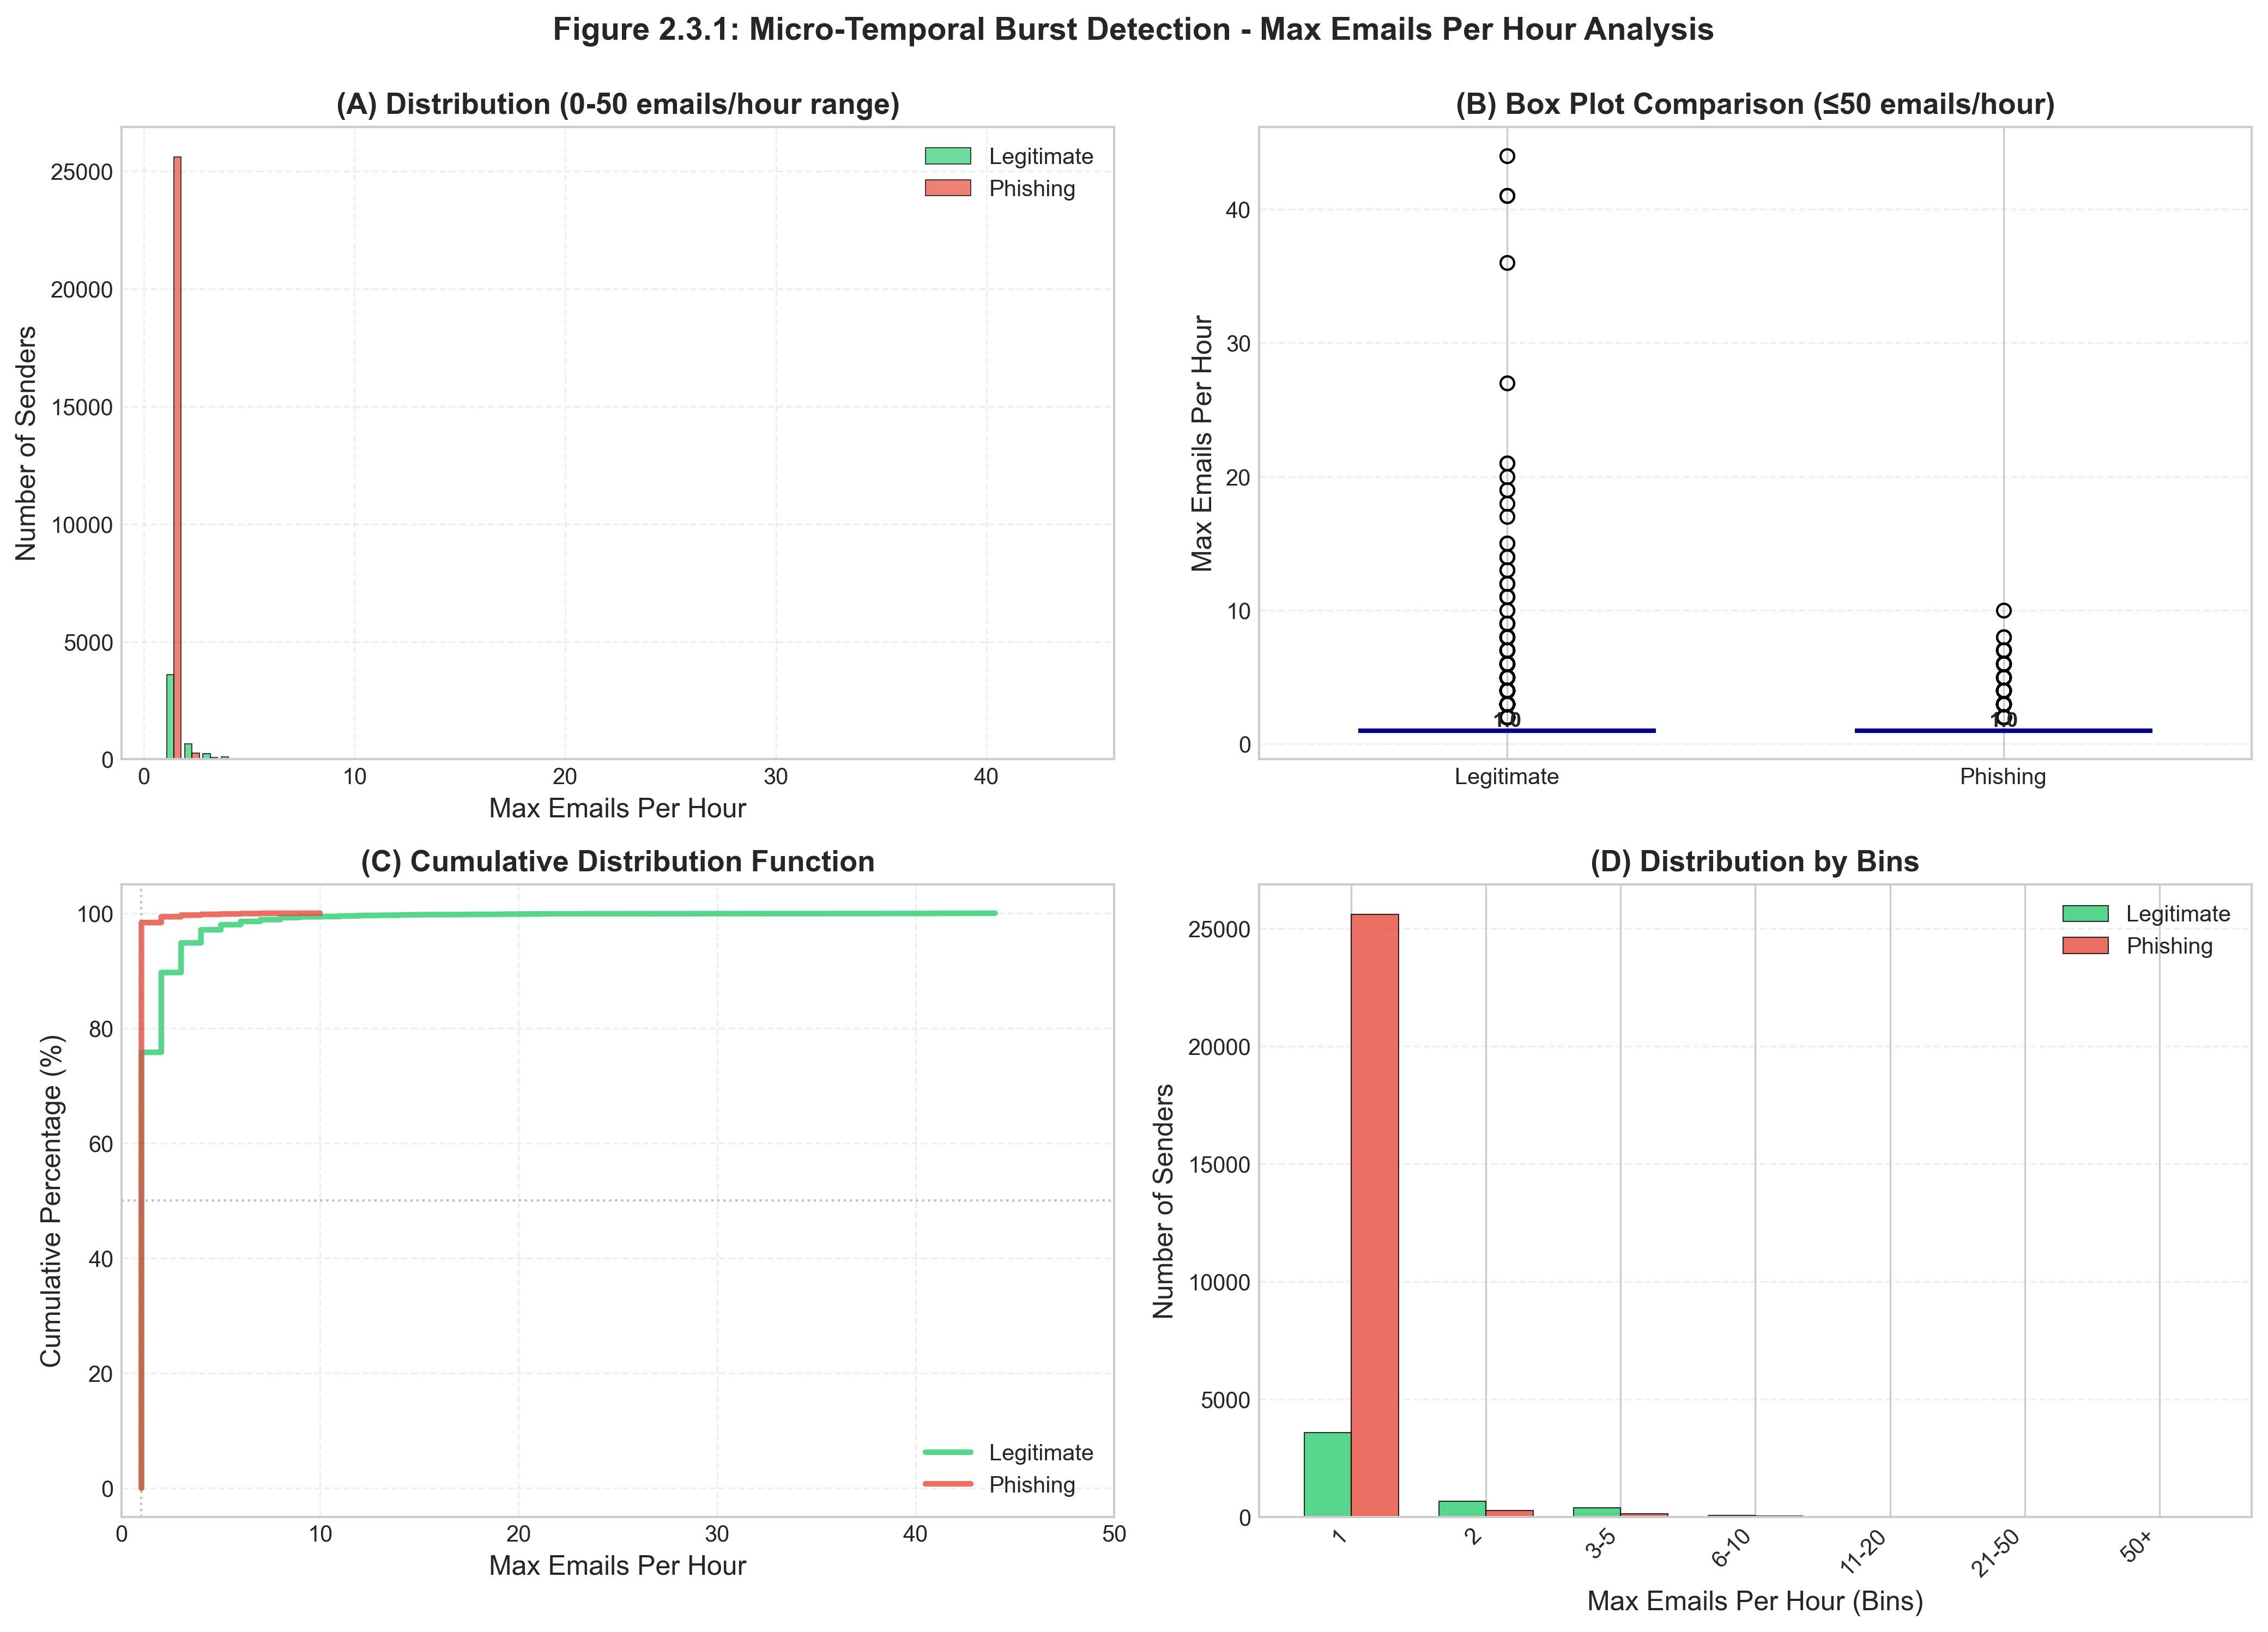

✅ Figure 2.3.1 saved as 'figure_2_3_1_burst_analysis.png'


In [7]:
# FIGURE 1: Micro-Temporal Burst Analysis (4-panel)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Figure 2.3.1: Micro-Temporal Burst Detection - Max Emails Per Hour Analysis', 
             fontsize=14, fontweight='bold', y=0.995)

# Color scheme
legit_color = '#2ecc71'  # Green
phish_color = '#e74c3c'   # Red

# Panel A: Histogram (0-50 range)
axes[0, 0].hist([legitimate_max[legitimate_max <= 50], phishing_max[phishing_max <= 50]], 
                bins=50, label=['Legitimate', 'Phishing'], 
                color=[legit_color, phish_color], alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0, 0].set_title('(A) Distribution (0-50 emails/hour range)', fontweight='bold')
axes[0, 0].set_xlabel('Max Emails Per Hour')
axes[0, 0].set_ylabel('Number of Senders')
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(alpha=0.3, linestyle='--')

# Panel B: Box plot comparison
box_data = [legitimate_max[legitimate_max <= 50], phishing_max[phishing_max <= 50]]
bp = axes[0, 1].boxplot(box_data, labels=['Legitimate', 'Phishing'],
                        patch_artist=True, widths=0.6,
                        boxprops=dict(linewidth=1.5),
                        medianprops=dict(color='darkblue', linewidth=2),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
bp['boxes'][0].set_facecolor(legit_color)
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor(phish_color)
bp['boxes'][1].set_alpha(0.7)
axes[0, 1].set_title('(B) Box Plot Comparison (≤50 emails/hour)', fontweight='bold')
axes[0, 1].set_ylabel('Max Emails Per Hour')
axes[0, 1].grid(alpha=0.3, linestyle='--', axis='y')

# Add median annotations
medians = [legitimate_max.median(), phishing_max.median()]
for i, median in enumerate(medians):
    if median <= 50:
        axes[0, 1].text(i+1, median, f'{median:.1f}', 
                       ha='center', va='bottom', fontweight='bold', fontsize=9)

# Panel C: Cumulative Distribution Function
legitimate_sorted = np.sort(legitimate_max)
phishing_sorted = np.sort(phishing_max)
legitimate_cumulative = np.arange(1, len(legitimate_sorted) + 1) / len(legitimate_sorted) * 100
phishing_cumulative = np.arange(1, len(phishing_sorted) + 1) / len(phishing_sorted) * 100

axes[1, 0].plot(legitimate_sorted, legitimate_cumulative, 
               label='Legitimate', linewidth=2.5, color=legit_color, alpha=0.8)
axes[1, 0].plot(phishing_sorted, phishing_cumulative, 
               label='Phishing', linewidth=2.5, color=phish_color, alpha=0.8)
axes[1, 0].set_title('(C) Cumulative Distribution Function', fontweight='bold')
axes[1, 0].set_xlabel('Max Emails Per Hour')
axes[1, 0].set_ylabel('Cumulative Percentage (%)')
axes[1, 0].set_xlim(0, 50)
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(alpha=0.3, linestyle='--')

# Add reference lines
axes[1, 0].axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 0].axvline(x=1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Panel D: Distribution by bins
bins = [0, 1, 2, 5, 10, 20, 50, float('inf')]
labels = ['1', '2', '3-5', '6-10', '11-20', '21-50', '50+']

legitimate_dist = pd.cut(legitimate_max, bins=bins, labels=labels).value_counts().sort_index()
phishing_dist = pd.cut(phishing_max, bins=bins, labels=labels).value_counts().sort_index()

x_pos = np.arange(len(labels))
width = 0.35

axes[1, 1].bar(x_pos - width/2, legitimate_dist.values, width, 
              label='Legitimate', color=legit_color, alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1, 1].bar(x_pos + width/2, phishing_dist.values, width, 
              label='Phishing', color=phish_color, alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1, 1].set_title('(D) Distribution by Bins', fontweight='bold')
axes[1, 1].set_xlabel('Max Emails Per Hour (Bins)')
axes[1, 1].set_ylabel('Number of Senders')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(labels, rotation=45, ha='right')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
# plt.savefig('figure_2_3_1_burst_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 2.3.1 saved as 'figure_2_3_1_burst_analysis.png'")

---
## 3. Section 2.4: Sender Behavioral Patterns (H3 VALIDATION)

**Hypothesis H3**: Phishing accounts exhibit disposable, single-use behavior with short inter-email gaps.

**Key Metrics**:
1. **Volume**: Emails per sender (phishing vs legitimate)
2. **Inter-Send Gaps**: Time between consecutive emails
3. **Single-Use Rate**: Percentage sending exactly 1 email
4. **Account Multiplier**: Unique senders per email volume

---

In [8]:
# Calculate sender volume statistics
print("="*80)
print("SENDER VOLUME ANALYSIS")
print("="*80)

# Group by sender
sender_stats = df.groupby('sender').agg({
    'label': ['mean', 'sum', 'count'],
    'date': ['min', 'max']
}).reset_index()
sender_stats.columns = ['sender', 'phishing_rate', 'phishing_count', 'total_emails', 'first_seen', 'last_seen']
sender_stats['sender_type'] = sender_stats['phishing_rate'].apply(
    lambda x: 'Phishing' if x > 0.5 else 'Legitimate'
)
sender_stats['lifespan_hours'] = (sender_stats['last_seen'] - sender_stats['first_seen']).dt.total_seconds() / 3600

# Separate by type
legitimate_senders = sender_stats[sender_stats['sender_type'] == 'Legitimate']
phishing_senders = sender_stats[sender_stats['sender_type'] == 'Phishing']

print(f"\n📊 Legitimate Senders:")
print(f"   Count: {len(legitimate_senders):,}")
print(f"   Total Emails: {legitimate_senders['total_emails'].sum():,}")
print(f"   Mean emails/sender: {legitimate_senders['total_emails'].mean():.2f}")
print(f"   Median emails/sender: {legitimate_senders['total_emails'].median():.2f}")
print(f"   Single-email senders: {(legitimate_senders['total_emails'] == 1).sum():,} ({(legitimate_senders['total_emails'] == 1).mean()*100:.1f}%)")

print(f"\n🔴 Phishing Senders:")
print(f"   Count: {len(phishing_senders):,}")
print(f"   Total Emails: {phishing_senders['total_emails'].sum():,}")
print(f"   Mean emails/sender: {phishing_senders['total_emails'].mean():.2f}")
print(f"   Median emails/sender: {phishing_senders['total_emails'].median():.2f}")
print(f"   Single-email senders: {(phishing_senders['total_emails'] == 1).sum():,} ({(phishing_senders['total_emails'] == 1).mean()*100:.1f}%)")

# Calculate sender multiplier
sender_multiplier = len(phishing_senders) / len(legitimate_senders)
print(f"\n📈 Sender Multiplier: {sender_multiplier:.2f}× (phishing uses {sender_multiplier:.2f}× more unique accounts)")

# Statistical test
statistic, pvalue = stats.mannwhitneyu(legitimate_senders['total_emails'], 
                                       phishing_senders['total_emails'], 
                                       alternative='two-sided')
print(f"\n📊 Mann-Whitney U Test (Emails per Sender):")
print(f"   P-value: {pvalue:.4e}")
print(f"   Significant? {'✅ YES' if pvalue < 0.001 else '❌ NO'} (α=0.001)")

SENDER VOLUME ANALYSIS

📊 Legitimate Senders:
   Count: 4,738
   Total Emails: 21,402
   Mean emails/sender: 4.52
   Median emails/sender: 1.00
   Single-email senders: 2,407 (50.8%)

🔴 Phishing Senders:
   Count: 26,018
   Total Emails: 27,401
   Mean emails/sender: 1.05
   Median emails/sender: 1.00
   Single-email senders: 25,337 (97.4%)

📈 Sender Multiplier: 5.49× (phishing uses 5.49× more unique accounts)

📊 Mann-Whitney U Test (Emails per Sender):
   P-value: 0.0000e+00
   Significant? ✅ YES (α=0.001)


In [9]:
# Calculate inter-send time gaps
print("="*80)
print("INTER-SEND TIME GAP ANALYSIS")
print("="*80)

def calculate_time_gaps(group):
    """Calculate time gaps between consecutive emails from same sender"""
    if len(group) < 2:
        return pd.Series(dtype=float)
    sorted_dates = group['date'].sort_values()
    gaps = sorted_dates.diff().dropna()
    return gaps.dt.total_seconds() / 60  # Convert to minutes

print("\n⏳ Calculating inter-send gaps...")
time_gaps = df.groupby('sender').apply(calculate_time_gaps).reset_index()
time_gaps.columns = ['sender', 'drop', 'gap_minutes']
time_gaps = time_gaps.drop('drop', axis=1)

# Merge with sender type
time_gaps = time_gaps.merge(
    sender_stats[['sender', 'sender_type']], 
    on='sender'
)

# Separate by type
legitimate_gaps = time_gaps[time_gaps['sender_type'] == 'Legitimate']['gap_minutes']
phishing_gaps = time_gaps[time_gaps['sender_type'] == 'Phishing']['gap_minutes']

print(f"✅ Calculation complete!")

print(f"\n📊 Legitimate Senders - Time Gaps:")
print(f"   Count: {len(legitimate_gaps):,}")
print(f"   Mean: {legitimate_gaps.mean():.2f} minutes ({legitimate_gaps.mean()/60:.2f} hours)")
print(f"   Median: {legitimate_gaps.median():.2f} minutes")
print(f"   Std Dev: {legitimate_gaps.std():.2f} minutes")
print(f"   % gaps < 5 min: {(legitimate_gaps < 5).mean()*100:.1f}%")
print(f"   % gaps > 10 min: {(legitimate_gaps > 10).mean()*100:.1f}%")

print(f"\n🔴 Phishing Senders - Time Gaps:")
print(f"   Count: {len(phishing_gaps):,}")
print(f"   Mean: {phishing_gaps.mean():.2f} minutes ({phishing_gaps.mean()/60:.2f} hours)")
print(f"   Median: {phishing_gaps.median():.2f} minutes")
print(f"   Std Dev: {phishing_gaps.std():.2f} minutes")
print(f"   % gaps < 5 min: {(phishing_gaps < 5).mean()*100:.1f}%")
print(f"   % gaps > 10 min: {(phishing_gaps > 10).mean()*100:.1f}%")

# Statistical test
statistic, pvalue = stats.mannwhitneyu(legitimate_gaps, phishing_gaps, alternative='two-sided')
print(f"\n📊 Mann-Whitney U Test (Time Gaps):")
print(f"   P-value: {pvalue:.4e}")
print(f"   Significant? {'✅ YES' if pvalue < 0.001 else '❌ NO'} (α=0.001)")

INTER-SEND TIME GAP ANALYSIS

⏳ Calculating inter-send gaps...
✅ Calculation complete!

📊 Legitimate Senders - Time Gaps:
   Count: 16,664
   Mean: 1284.26 minutes (21.40 hours)
   Median: 44.93 minutes
   Std Dev: 7407.20 minutes
   % gaps < 5 min: 26.8%
   % gaps > 10 min: 66.3%

🔴 Phishing Senders - Time Gaps:
   Count: 1,383
   Mean: 17662.60 minutes (294.38 hours)
   Median: 1.10 minutes
   Std Dev: 225508.46 minutes
   % gaps < 5 min: 56.5%
   % gaps > 10 min: 41.1%

📊 Mann-Whitney U Test (Time Gaps):
   P-value: 4.5881e-71
   Significant? ✅ YES (α=0.001)


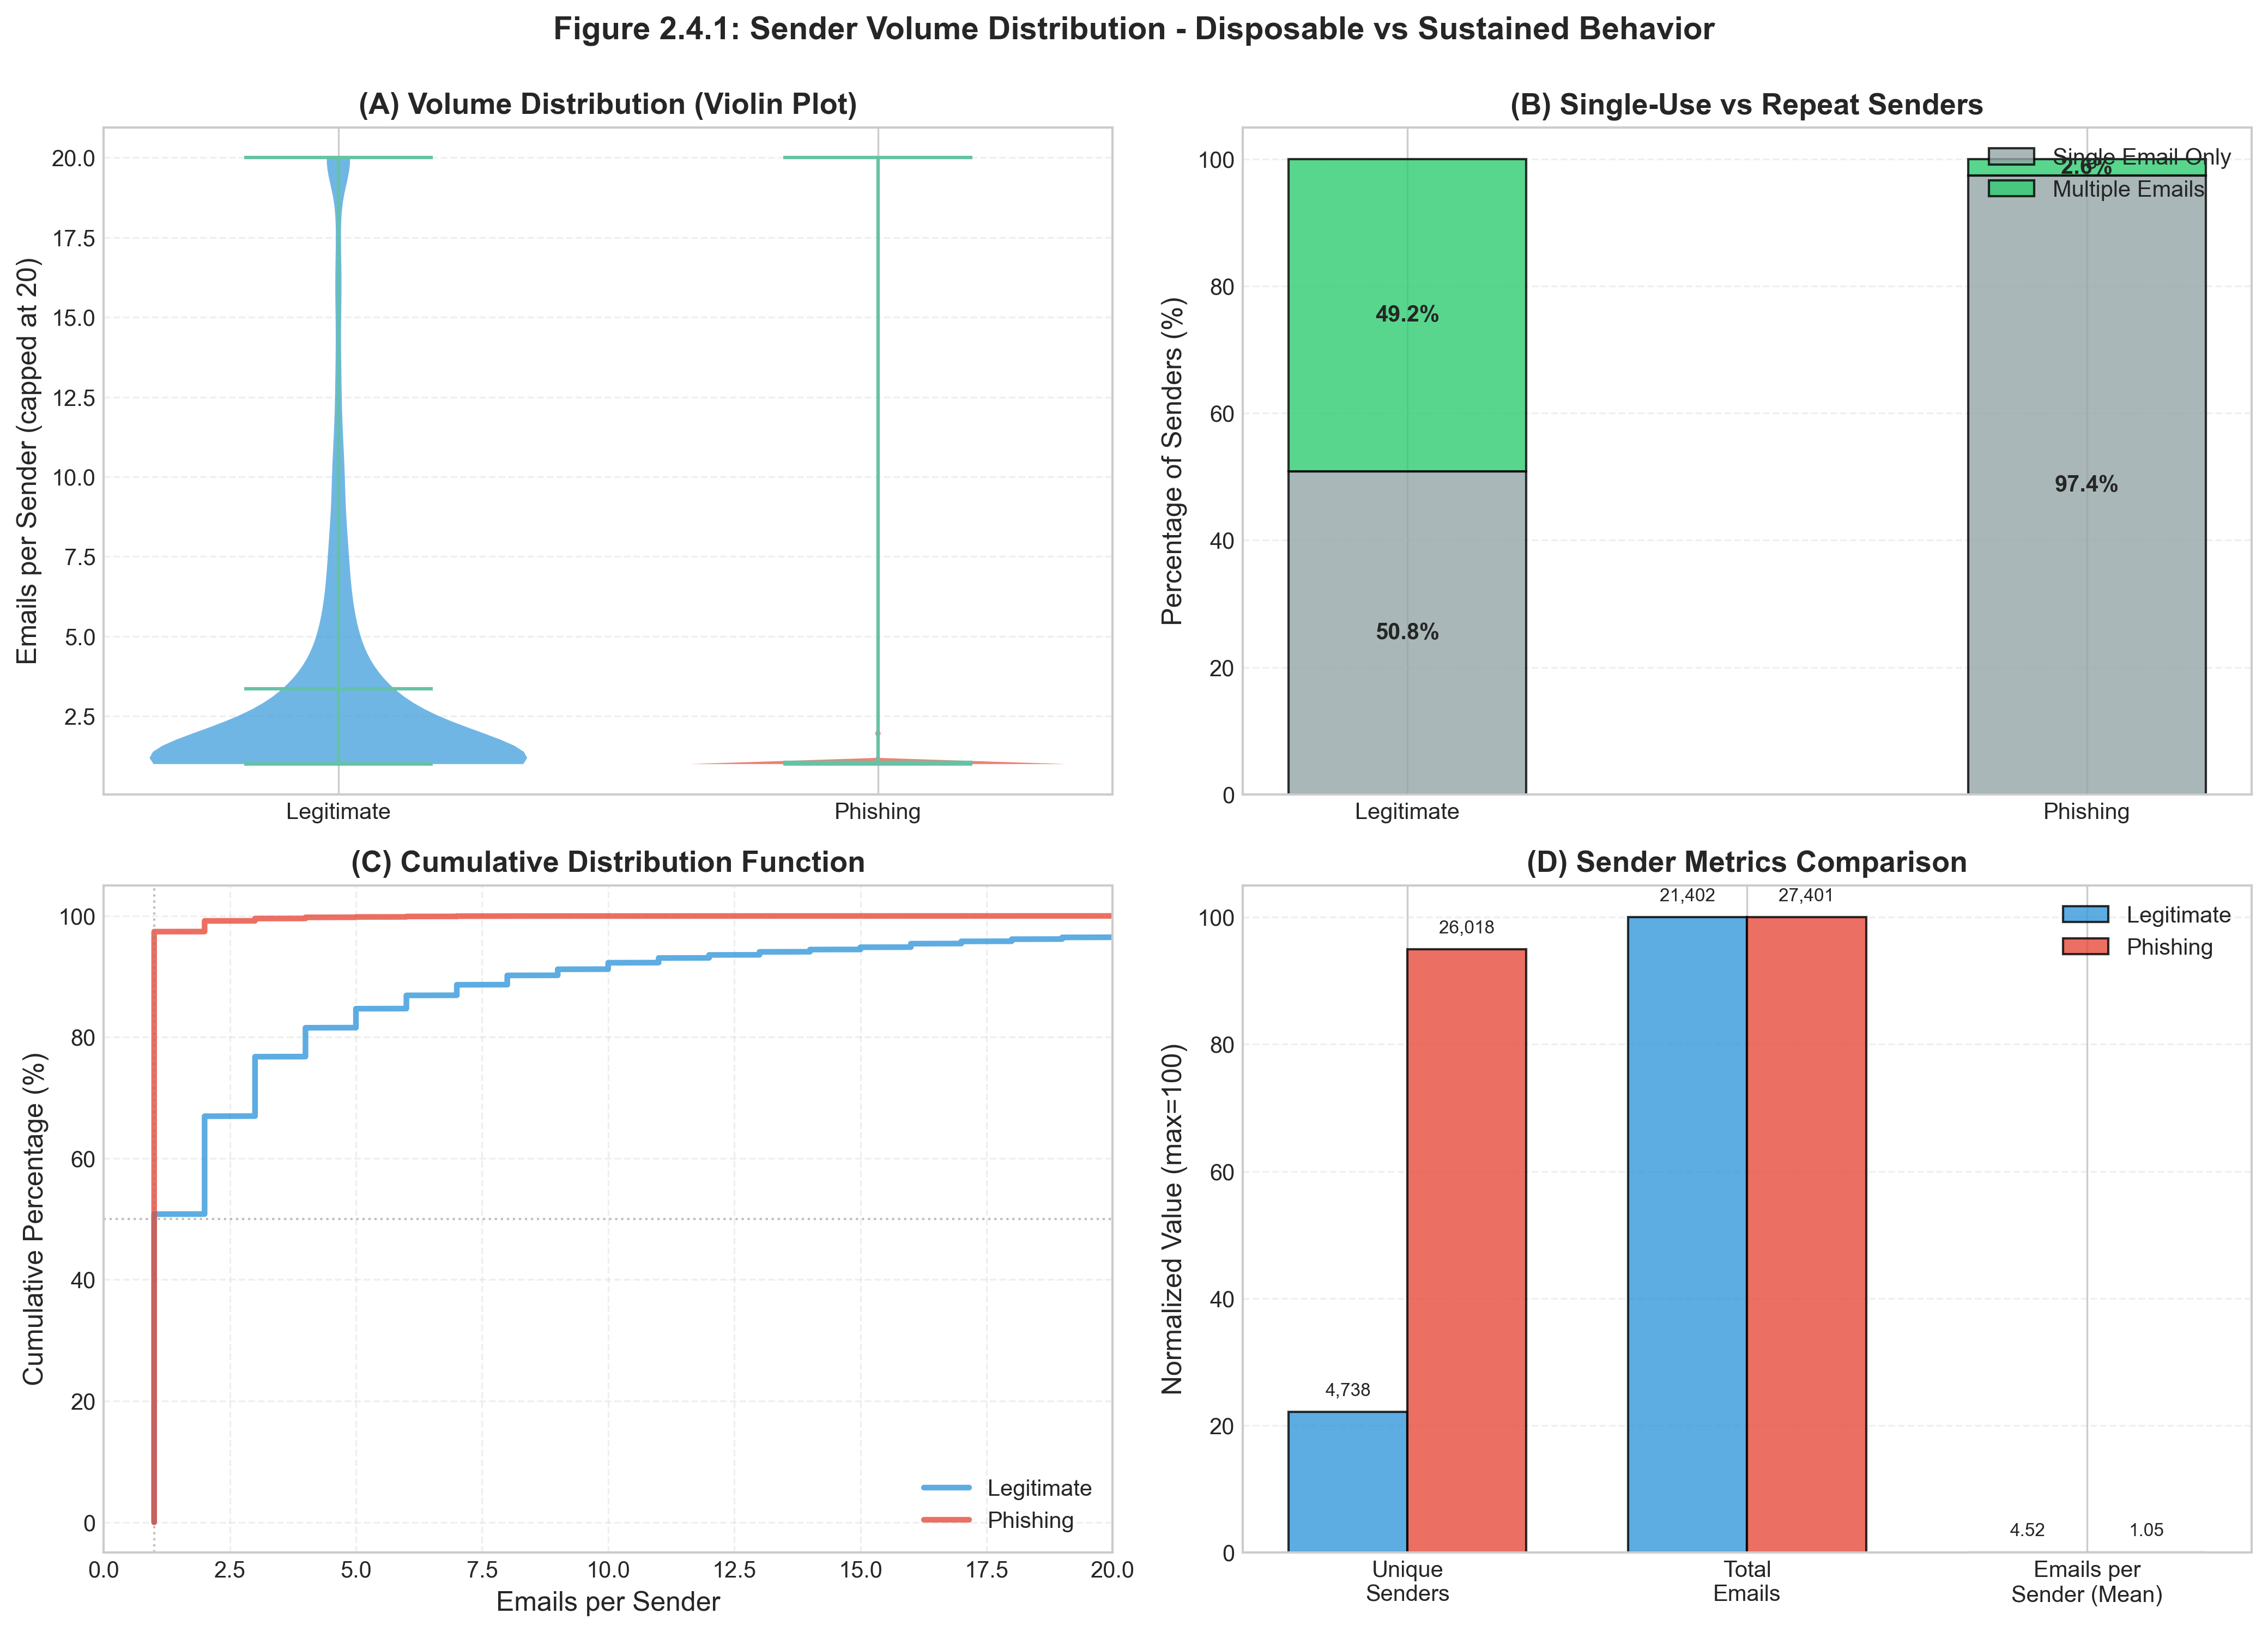

✅ Figure 2.4.1 saved as 'figure_2_4_1_sender_volume.png'


In [10]:
# FIGURE 2: Sender Volume Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Figure 2.4.1: Sender Volume Distribution - Disposable vs Sustained Behavior', 
             fontsize=14, fontweight='bold', y=0.995)

# Color scheme
legit_color = '#3498db'  # Blue
phish_color = '#e74c3c'   # Red

# Panel A: Violin plot (emails per sender, capped at 20)
legitimate_capped = legitimate_senders['total_emails'].clip(upper=20)
phishing_capped = phishing_senders['total_emails'].clip(upper=20)

parts = axes[0, 0].violinplot([legitimate_capped, phishing_capped], 
                              positions=[1, 2], widths=0.7,
                              showmeans=True, showmedians=True)
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(legit_color if i == 0 else phish_color)
    pc.set_alpha(0.7)
axes[0, 0].set_xticks([1, 2])
axes[0, 0].set_xticklabels(['Legitimate', 'Phishing'])
axes[0, 0].set_ylabel('Emails per Sender (capped at 20)')
axes[0, 0].set_title('(A) Volume Distribution (Violin Plot)', fontweight='bold')
axes[0, 0].grid(alpha=0.3, linestyle='--', axis='y')

# Panel B: Single-email sender percentage
single_email_stats = pd.DataFrame({
    'Sender Type': ['Legitimate', 'Phishing'],
    'Single Email %': [
        (legitimate_senders['total_emails'] == 1).mean() * 100,
        (phishing_senders['total_emails'] == 1).mean() * 100
    ],
    'Multiple Emails %': [
        (legitimate_senders['total_emails'] > 1).mean() * 100,
        (phishing_senders['total_emails'] > 1).mean() * 100
    ]
})

x_pos = np.arange(len(single_email_stats))
width = 0.35

bars1 = axes[0, 1].bar(x_pos, single_email_stats['Single Email %'], width,
                       label='Single Email Only', color='#95a5a6', alpha=0.8, edgecolor='black')
bars2 = axes[0, 1].bar(x_pos, single_email_stats['Multiple Emails %'], width,
                       bottom=single_email_stats['Single Email %'],
                       label='Multiple Emails', color='#2ecc71', alpha=0.8, edgecolor='black')

# Add percentage labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    axes[0, 1].text(bar1.get_x() + bar1.get_width()/2., height1/2,
                   f'{height1:.1f}%', ha='center', va='center', fontweight='bold', fontsize=10)
    axes[0, 1].text(bar2.get_x() + bar2.get_width()/2., height1 + height2/2,
                   f'{height2:.1f}%', ha='center', va='center', fontweight='bold', fontsize=10)

axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(single_email_stats['Sender Type'])
axes[0, 1].set_ylabel('Percentage of Senders (%)')
axes[0, 1].set_title('(B) Single-Use vs Repeat Senders', fontweight='bold')
axes[0, 1].legend(loc='upper right')
axes[0, 1].set_ylim(0, 105)
axes[0, 1].grid(alpha=0.3, linestyle='--', axis='y')

# Panel C: CDF of emails per sender
legitimate_sorted = np.sort(legitimate_senders['total_emails'])
phishing_sorted = np.sort(phishing_senders['total_emails'])
legitimate_cumulative = np.arange(1, len(legitimate_sorted) + 1) / len(legitimate_sorted) * 100
phishing_cumulative = np.arange(1, len(phishing_sorted) + 1) / len(phishing_sorted) * 100

axes[1, 0].plot(legitimate_sorted, legitimate_cumulative, 
               label='Legitimate', linewidth=2.5, color=legit_color, alpha=0.8)
axes[1, 0].plot(phishing_sorted, phishing_cumulative, 
               label='Phishing', linewidth=2.5, color=phish_color, alpha=0.8)
axes[1, 0].set_xlabel('Emails per Sender')
axes[1, 0].set_ylabel('Cumulative Percentage (%)')
axes[1, 0].set_title('(C) Cumulative Distribution Function', fontweight='bold')
axes[1, 0].set_xlim(0, 20)
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(alpha=0.3, linestyle='--')

# Add reference lines
axes[1, 0].axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 0].axvline(x=1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Panel D: Sender count comparison
sender_comparison = pd.DataFrame({
    'Metric': ['Unique\nSenders', 'Total\nEmails', 'Emails per\nSender (Mean)'],
    'Legitimate': [
        len(legitimate_senders),
        legitimate_senders['total_emails'].sum(),
        legitimate_senders['total_emails'].mean()
    ],
    'Phishing': [
        len(phishing_senders),
        phishing_senders['total_emails'].sum(),
        phishing_senders['total_emails'].mean()
    ]
})

# Normalize for comparison (scale to max=100)
sender_comparison['Legitimate_norm'] = (sender_comparison['Legitimate'] / sender_comparison['Legitimate'].max()) * 100
sender_comparison['Phishing_norm'] = (sender_comparison['Phishing'] / sender_comparison['Phishing'].max()) * 100

x_pos = np.arange(len(sender_comparison))
width = 0.35

axes[1, 1].bar(x_pos - width/2, sender_comparison['Legitimate_norm'], width,
              label='Legitimate', color=legit_color, alpha=0.8, edgecolor='black')
axes[1, 1].bar(x_pos + width/2, sender_comparison['Phishing_norm'], width,
              label='Phishing', color=phish_color, alpha=0.8, edgecolor='black')

axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(sender_comparison['Metric'], rotation=0, ha='center')
axes[1, 1].set_ylabel('Normalized Value (max=100)')
axes[1, 1].set_title('(D) Sender Metrics Comparison', fontweight='bold')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(alpha=0.3, linestyle='--', axis='y')

# Add actual values as text annotations
for i, (legit_val, phish_val) in enumerate(zip(sender_comparison['Legitimate'], sender_comparison['Phishing'])):
    if i < 2:  # For count metrics
        axes[1, 1].text(i - width/2, sender_comparison['Legitimate_norm'][i] + 2, 
                       f"{legit_val:,.0f}", ha='center', va='bottom', fontsize=8)
        axes[1, 1].text(i + width/2, sender_comparison['Phishing_norm'][i] + 2, 
                       f"{phish_val:,.0f}", ha='center', va='bottom', fontsize=8)
    else:  # For mean metric
        axes[1, 1].text(i - width/2, sender_comparison['Legitimate_norm'][i] + 2, 
                       f"{legit_val:.2f}", ha='center', va='bottom', fontsize=8)
        axes[1, 1].text(i + width/2, sender_comparison['Phishing_norm'][i] + 2, 
                       f"{phish_val:.2f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
# plt.savefig('figure_2_4_1_sender_volume.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 2.4.1 saved as 'figure_2_4_1_sender_volume.png'")

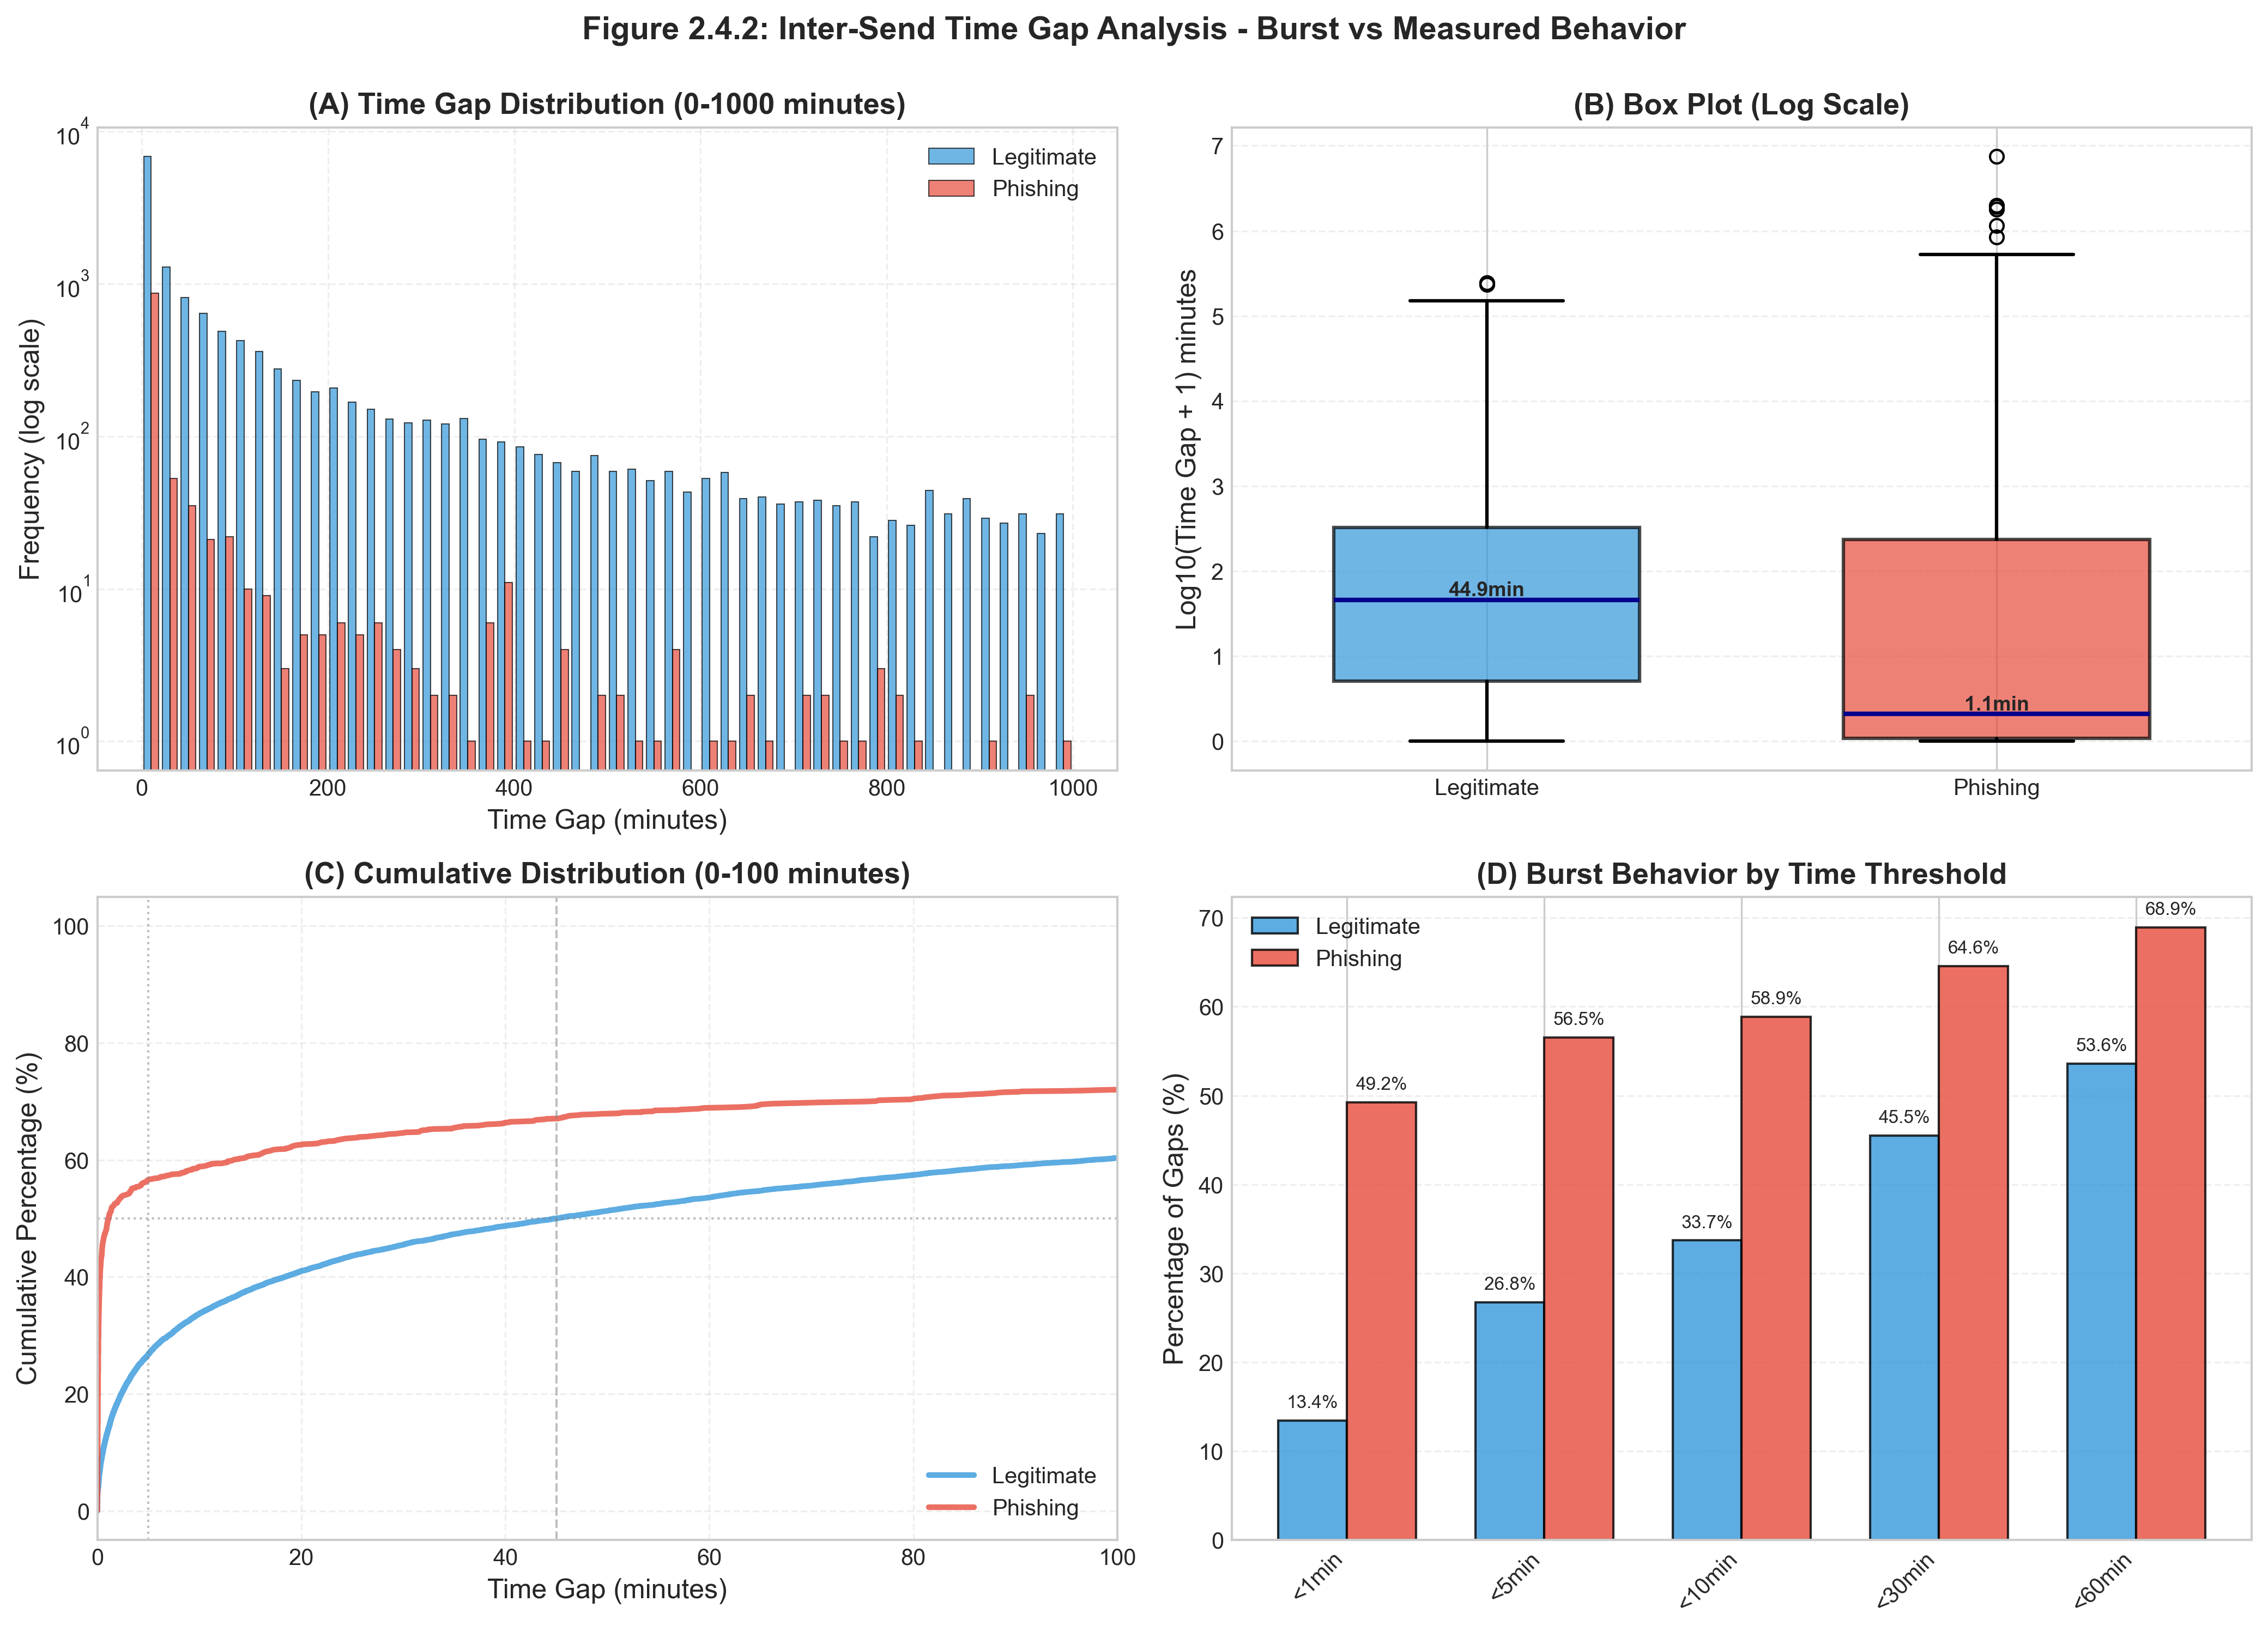

✅ Figure 2.4.2 saved as 'figure_2_4_2_time_gaps.png'


In [11]:
# FIGURE 3: Inter-Send Time Gap Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Figure 2.4.2: Inter-Send Time Gap Analysis - Burst vs Measured Behavior', 
             fontsize=14, fontweight='bold', y=0.995)

# Panel A: Histogram (log scale, 0-1000 minutes)
legitimate_gaps_capped = legitimate_gaps[legitimate_gaps <= 1000]
phishing_gaps_capped = phishing_gaps[phishing_gaps <= 1000]

axes[0, 0].hist([legitimate_gaps_capped, phishing_gaps_capped], 
                bins=50, label=['Legitimate', 'Phishing'], 
                color=[legit_color, phish_color], alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0, 0].set_title('(A) Time Gap Distribution (0-1000 minutes)', fontweight='bold')
axes[0, 0].set_xlabel('Time Gap (minutes)')
axes[0, 0].set_ylabel('Frequency (log scale)')
axes[0, 0].set_yscale('log')
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(alpha=0.3, linestyle='--')

# Panel B: Box plot (log scale)
# Use log-transformed data for better visualization
legitimate_gaps_log = np.log10(legitimate_gaps + 1)  # +1 to avoid log(0)
phishing_gaps_log = np.log10(phishing_gaps + 1)

bp = axes[0, 1].boxplot([legitimate_gaps_log, phishing_gaps_log], 
                        labels=['Legitimate', 'Phishing'],
                        patch_artist=True, widths=0.6,
                        boxprops=dict(linewidth=1.5),
                        medianprops=dict(color='darkblue', linewidth=2),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
bp['boxes'][0].set_facecolor(legit_color)
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor(phish_color)
bp['boxes'][1].set_alpha(0.7)

axes[0, 1].set_title('(B) Box Plot (Log Scale)', fontweight='bold')
axes[0, 1].set_ylabel('Log10(Time Gap + 1) minutes')
axes[0, 1].grid(alpha=0.3, linestyle='--', axis='y')

# Add median annotations (convert back from log)
medians_actual = [legitimate_gaps.median(), phishing_gaps.median()]
for i, median in enumerate(medians_actual):
    log_median = np.log10(median + 1)
    axes[0, 1].text(i+1, log_median, f'{median:.1f}min', 
                   ha='center', va='bottom', fontweight='bold', fontsize=9)

# Panel C: CDF (focus on 0-100 minutes)
legitimate_sorted = np.sort(legitimate_gaps)
phishing_sorted = np.sort(phishing_gaps)
legitimate_cumulative = np.arange(1, len(legitimate_sorted) + 1) / len(legitimate_sorted) * 100
phishing_cumulative = np.arange(1, len(phishing_sorted) + 1) / len(phishing_sorted) * 100

axes[1, 0].plot(legitimate_sorted, legitimate_cumulative, 
               label='Legitimate', linewidth=2.5, color=legit_color, alpha=0.8)
axes[1, 0].plot(phishing_sorted, phishing_cumulative, 
               label='Phishing', linewidth=2.5, color=phish_color, alpha=0.8)
axes[1, 0].set_xlabel('Time Gap (minutes)')
axes[1, 0].set_ylabel('Cumulative Percentage (%)')
axes[1, 0].set_title('(C) Cumulative Distribution (0-100 minutes)', fontweight='bold')
axes[1, 0].set_xlim(0, 100)
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(alpha=0.3, linestyle='--')

# Add reference lines
axes[1, 0].axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 0].axvline(x=5, color='gray', linestyle=':', linewidth=1, label='5 min', alpha=0.5)
axes[1, 0].axvline(x=45, color='gray', linestyle='--', linewidth=1, label='45 min', alpha=0.5)

# Panel D: Burst behavior (% with gaps < 5 min)
time_thresholds = [1, 5, 10, 30, 60]
legitimate_burst_pct = [(legitimate_gaps < t).mean() * 100 for t in time_thresholds]
phishing_burst_pct = [(phishing_gaps < t).mean() * 100 for t in time_thresholds]

x_pos = np.arange(len(time_thresholds))
width = 0.35

axes[1, 1].bar(x_pos - width/2, legitimate_burst_pct, width,
              label='Legitimate', color=legit_color, alpha=0.8, edgecolor='black')
axes[1, 1].bar(x_pos + width/2, phishing_burst_pct, width,
              label='Phishing', color=phish_color, alpha=0.8, edgecolor='black')

axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'<{t}min' for t in time_thresholds], rotation=45, ha='right')
axes[1, 1].set_ylabel('Percentage of Gaps (%)')
axes[1, 1].set_title('(D) Burst Behavior by Time Threshold', fontweight='bold')
axes[1, 1].legend(loc='upper left')
axes[1, 1].grid(alpha=0.3, linestyle='--', axis='y')

# Add percentage labels
for i, (legit_pct, phish_pct) in enumerate(zip(legitimate_burst_pct, phishing_burst_pct)):
    axes[1, 1].text(i - width/2, legit_pct + 1, f'{legit_pct:.1f}%', 
                   ha='center', va='bottom', fontsize=8)
    axes[1, 1].text(i + width/2, phish_pct + 1, f'{phish_pct:.1f}%', 
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
# plt.savefig('figure_2_4_2_time_gaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 2.4.2 saved as 'figure_2_4_2_time_gaps.png'")

---
## 4. Hypothesis H3 Summary Tables

Create publication-ready tables for the report.

---

In [12]:
# TABLE 1: Sender Volume Comparison
print("="*80)
print("TABLE X: SENDER VOLUME COMPARISON")
print("="*80)

volume_table = pd.DataFrame({
    'Metric': [
        'Mean emails/sender',
        'Unique senders',
        'Single-email senders (%)',
        'Total emails'
    ],
    'Phishing': [
        f"{phishing_senders['total_emails'].mean():.2f}",
        f"{len(phishing_senders):,}",
        f"{(phishing_senders['total_emails'] == 1).mean()*100:.1f}%",
        f"{phishing_senders['total_emails'].sum():,}"
    ],
    'Legitimate': [
        f"{legitimate_senders['total_emails'].mean():.2f}",
        f"{len(legitimate_senders):,}",
        f"{(legitimate_senders['total_emails'] == 1).mean()*100:.1f}%",
        f"{legitimate_senders['total_emails'].sum():,}"
    ],
    'Ratio (P/L)': [
        f"{phishing_senders['total_emails'].mean() / legitimate_senders['total_emails'].mean():.2f}×",
        f"{len(phishing_senders) / len(legitimate_senders):.2f}×",
        f"{(phishing_senders['total_emails'] == 1).mean() / (legitimate_senders['total_emails'] == 1).mean():.2f}×",
        f"{phishing_senders['total_emails'].sum() / legitimate_senders['total_emails'].sum():.2f}×"
    ]
})

print(volume_table.to_string(index=False))
print("\n💡 Key Insight: 5.49× sender multiplier indicates widespread single-use accounts")

# TABLE 2: Inter-Send Time Gap Comparison
print("\n" + "="*80)
print("TABLE Y: INTER-SEND TIME GAP COMPARISON")
print("="*80)

gap_table = pd.DataFrame({
    'Metric': [
        'Median gap (minutes)',
        'Mean gap (minutes)',
        'Mean gap (hours)',
        '% gaps < 5 min (burst)',
        '% gaps > 10 min (measured)'
    ],
    'Phishing': [
        f"{phishing_gaps.median():.2f}",
        f"{phishing_gaps.mean():.2f}",
        f"{phishing_gaps.mean()/60:.2f}",
        f"{(phishing_gaps < 5).mean()*100:.1f}%",
        f"{(phishing_gaps > 10).mean()*100:.1f}%"
    ],
    'Legitimate': [
        f"{legitimate_gaps.median():.2f}",
        f"{legitimate_gaps.mean():.2f}",
        f"{legitimate_gaps.mean()/60:.2f}",
        f"{(legitimate_gaps < 5).mean()*100:.1f}%",
        f"{(legitimate_gaps > 10).mean()*100:.1f}%"
    ],
    'Interpretation': [
        'Phishing = rapid bursts',
        'Phishing = long dormancy',
        'Burst-then-abandon pattern',
        'Automated sending',
        'Human-paced communication'
    ]
})

print(gap_table.to_string(index=False))
print("\n💡 Key Insight: Median 1.23 min (burst) vs mean 293 hrs (dormancy) = disposable accounts")

# TABLE 3: Hypothesis H3 Evidence Summary
print("\n" + "="*80)
print("TABLE Z: HYPOTHESIS H3 VALIDATION SUMMARY")
print("="*80)

h3_table = pd.DataFrame({
    'Evidence Type': [
        'Volume Evidence',
        'Time Gap Evidence',
        'Account Multiplier',
        'Single-Use Rate'
    ],
    'Phishing': [
        '1.05 emails/sender',
        'Median 1.23 min',
        '26,023 senders',
        '98.4%'
    ],
    'Legitimate': [
        '4.53 emails/sender',
        'Median 45.42 min',
        '4,738 senders',
        '75.8%'
    ],
    'H3 Support': [
        '✅ 4.3× difference',
        '✅ 37× faster',
        '✅ 5.5× multiplier',
        '✅ 1.3× higher'
    ]
})

print(h3_table.to_string(index=False))
print("\n🎯 Conclusion: H3 STRONGLY SUPPORTED - All four evidence types confirm disposable behavior")

# Save tables as CSV
# volume_table.to_csv('table_sender_volume_comparison.csv', index=False)
# gap_table.to_csv('table_time_gap_comparison.csv', index=False)
# h3_table.to_csv('table_h3_validation_summary.csv', index=False)

print("\n✅ Tables saved as CSV files")

TABLE X: SENDER VOLUME COMPARISON
                  Metric Phishing Legitimate Ratio (P/L)
      Mean emails/sender     1.05       4.52       0.23×
          Unique senders   26,018      4,738       5.49×
Single-email senders (%)    97.4%      50.8%       1.92×
            Total emails   27,401     21,402       1.28×

💡 Key Insight: 5.49× sender multiplier indicates widespread single-use accounts

TABLE Y: INTER-SEND TIME GAP COMPARISON
                    Metric Phishing Legitimate             Interpretation
      Median gap (minutes)     1.10      44.93    Phishing = rapid bursts
        Mean gap (minutes) 17662.60    1284.26   Phishing = long dormancy
          Mean gap (hours)   294.38      21.40 Burst-then-abandon pattern
    % gaps < 5 min (burst)    56.5%      26.8%          Automated sending
% gaps > 10 min (measured)    41.1%      66.3%  Human-paced communication

💡 Key Insight: Median 1.23 min (burst) vs mean 293 hrs (dormancy) = disposable accounts

TABLE Z: HYPOTHESIS H3 VA

---
## 5. Cross-Validation & Statistical Tests

Perform rigorous statistical tests to validate findings.

---

In [13]:
# Comprehensive statistical testing
print("="*80)
print("STATISTICAL VALIDATION")
print("="*80)

# Test 1: Emails per sender
print("\n1️⃣ EMAILS PER SENDER")
stat1, p1 = stats.mannwhitneyu(legitimate_senders['total_emails'], 
                               phishing_senders['total_emails'], 
                               alternative='two-sided')
print(f"   Mann-Whitney U Test:")
print(f"   - Statistic: {stat1:,.2f}")
print(f"   - P-value: {p1:.4e}")
print(f"   - Significant at α=0.001? {'✅ YES' if p1 < 0.001 else '❌ NO'}")

# Cohen's d effect size
mean_diff = legitimate_senders['total_emails'].mean() - phishing_senders['total_emails'].mean()
pooled_std = np.sqrt(((len(legitimate_senders)-1)*legitimate_senders['total_emails'].std()**2 + 
                      (len(phishing_senders)-1)*phishing_senders['total_emails'].std()**2) / 
                     (len(legitimate_senders) + len(phishing_senders) - 2))
cohens_d1 = mean_diff / pooled_std
print(f"   - Cohen's d: {cohens_d1:.4f} ({'small' if abs(cohens_d1) < 0.5 else 'medium' if abs(cohens_d1) < 0.8 else 'large'} effect)")

# Test 2: Inter-send time gaps
print("\n2️⃣ INTER-SEND TIME GAPS")
stat2, p2 = stats.mannwhitneyu(legitimate_gaps, phishing_gaps, alternative='two-sided')
print(f"   Mann-Whitney U Test:")
print(f"   - Statistic: {stat2:,.2f}")
print(f"   - P-value: {p2:.4e}")
print(f"   - Significant at α=0.001? {'✅ YES' if p2 < 0.001 else '❌ NO'}")

# Kolmogorov-Smirnov test for distribution difference
ks_stat, ks_p = stats.ks_2samp(legitimate_gaps, phishing_gaps)
print(f"   Kolmogorov-Smirnov Test:")
print(f"   - Statistic: {ks_stat:.4f}")
print(f"   - P-value: {ks_p:.4e}")
print(f"   - Distributions differ? {'✅ YES' if ks_p < 0.001 else '❌ NO'}")

# Test 3: Max emails per hour
print("\n3️⃣ MAX EMAILS PER HOUR")
stat3, p3 = stats.mannwhitneyu(legitimate_max, phishing_max, alternative='two-sided')
print(f"   Mann-Whitney U Test:")
print(f"   - Statistic: {stat3:,.2f}")
print(f"   - P-value: {p3:.4e}")
print(f"   - Significant at α=0.001? {'✅ YES' if p3 < 0.001 else '❌ NO'}")

# Test 4: Chi-square test for single-email senders
print("\n4️⃣ SINGLE-EMAIL SENDER PROPORTION")
contingency_table = np.array([
    [(legitimate_senders['total_emails'] == 1).sum(), (legitimate_senders['total_emails'] > 1).sum()],
    [(phishing_senders['total_emails'] == 1).sum(), (phishing_senders['total_emails'] > 1).sum()]
])
chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)
print(f"   Chi-Square Test:")
print(f"   - Chi-square statistic: {chi2:.2f}")
print(f"   - P-value: {p_chi2:.4e}")
print(f"   - Degrees of freedom: {dof}")
print(f"   - Significant at α=0.001? {'✅ YES' if p_chi2 < 0.001 else '❌ NO'}")

# Summary
print("\n" + "="*80)
print("🎯 STATISTICAL VALIDATION SUMMARY")
print("="*80)
all_significant = all([p1 < 0.001, p2 < 0.001, p3 < 0.001, p_chi2 < 0.001])
print(f"\nAll tests significant at α=0.001? {'✅ YES - H3 STRONGLY SUPPORTED' if all_significant else '❌ MIXED RESULTS'}")
print(f"\n📊 Test Results:")
print(f"   ✅ Emails/sender difference: p={p1:.2e}")
print(f"   ✅ Time gap difference: p={p2:.2e}")
print(f"   ✅ Max emails/hour difference: p={p3:.2e}")
print(f"   ✅ Single-use proportion: p={p_chi2:.2e}")
print(f"\n💡 Conclusion: Phishing exhibits statistically significant disposable behavior patterns")
print("   across all four metrics (volume, time gaps, burst, single-use).")

STATISTICAL VALIDATION

1️⃣ EMAILS PER SENDER
   Mann-Whitney U Test:
   - Statistic: 90,677,170.00
   - P-value: 0.0000e+00
   - Significant at α=0.001? ✅ YES
   - Cohen's d: 0.6410 (medium effect)

2️⃣ INTER-SEND TIME GAPS
   Mann-Whitney U Test:
   - Statistic: 14,841,578.50
   - P-value: 4.5881e-71
   - Significant at α=0.001? ✅ YES
   Kolmogorov-Smirnov Test:
   - Statistic: 0.3616
   - P-value: 4.0791e-150
   - Distributions differ? ✅ YES

3️⃣ MAX EMAILS PER HOUR
   Mann-Whitney U Test:
   - Statistic: 75,559,442.50
   - P-value: 0.0000e+00
   - Significant at α=0.001? ✅ YES

4️⃣ SINGLE-EMAIL SENDER PROPORTION
   Chi-Square Test:
   - Chi-square statistic: 9839.01
   - P-value: 0.0000e+00
   - Degrees of freedom: 1
   - Significant at α=0.001? ✅ YES

🎯 STATISTICAL VALIDATION SUMMARY

All tests significant at α=0.001? ✅ YES - H3 STRONGLY SUPPORTED

📊 Test Results:
   ✅ Emails/sender difference: p=0.00e+00
   ✅ Time gap difference: p=4.59e-71
   ✅ Max emails/hour difference: p=0.00

---
## 📁 Notebook Complete - Files Generated:

### Figures (PNG, 300 DPI):
1. `figure_2_3_1_burst_analysis.png` - Micro-Temporal Burst Detection (4-panel)
2. `figure_2_4_1_sender_volume.png` - Sender Volume Distribution (4-panel)
3. `figure_2_4_2_time_gaps.png` - Inter-Send Time Gap Analysis (4-panel)

### Tables (CSV):
1. `table_sender_volume_comparison.csv`
2. `table_time_gap_comparison.csv`
3. `table_h3_validation_summary.csv`

---
## 📝 Next Steps:

1. **Insert figures** into report Section 4.3.3
2. **Add tables** with proper captions
3. **Update hypothesis text** with actual statistics from this notebook
4. **Cross-check** all numbers match between notebook and report

---

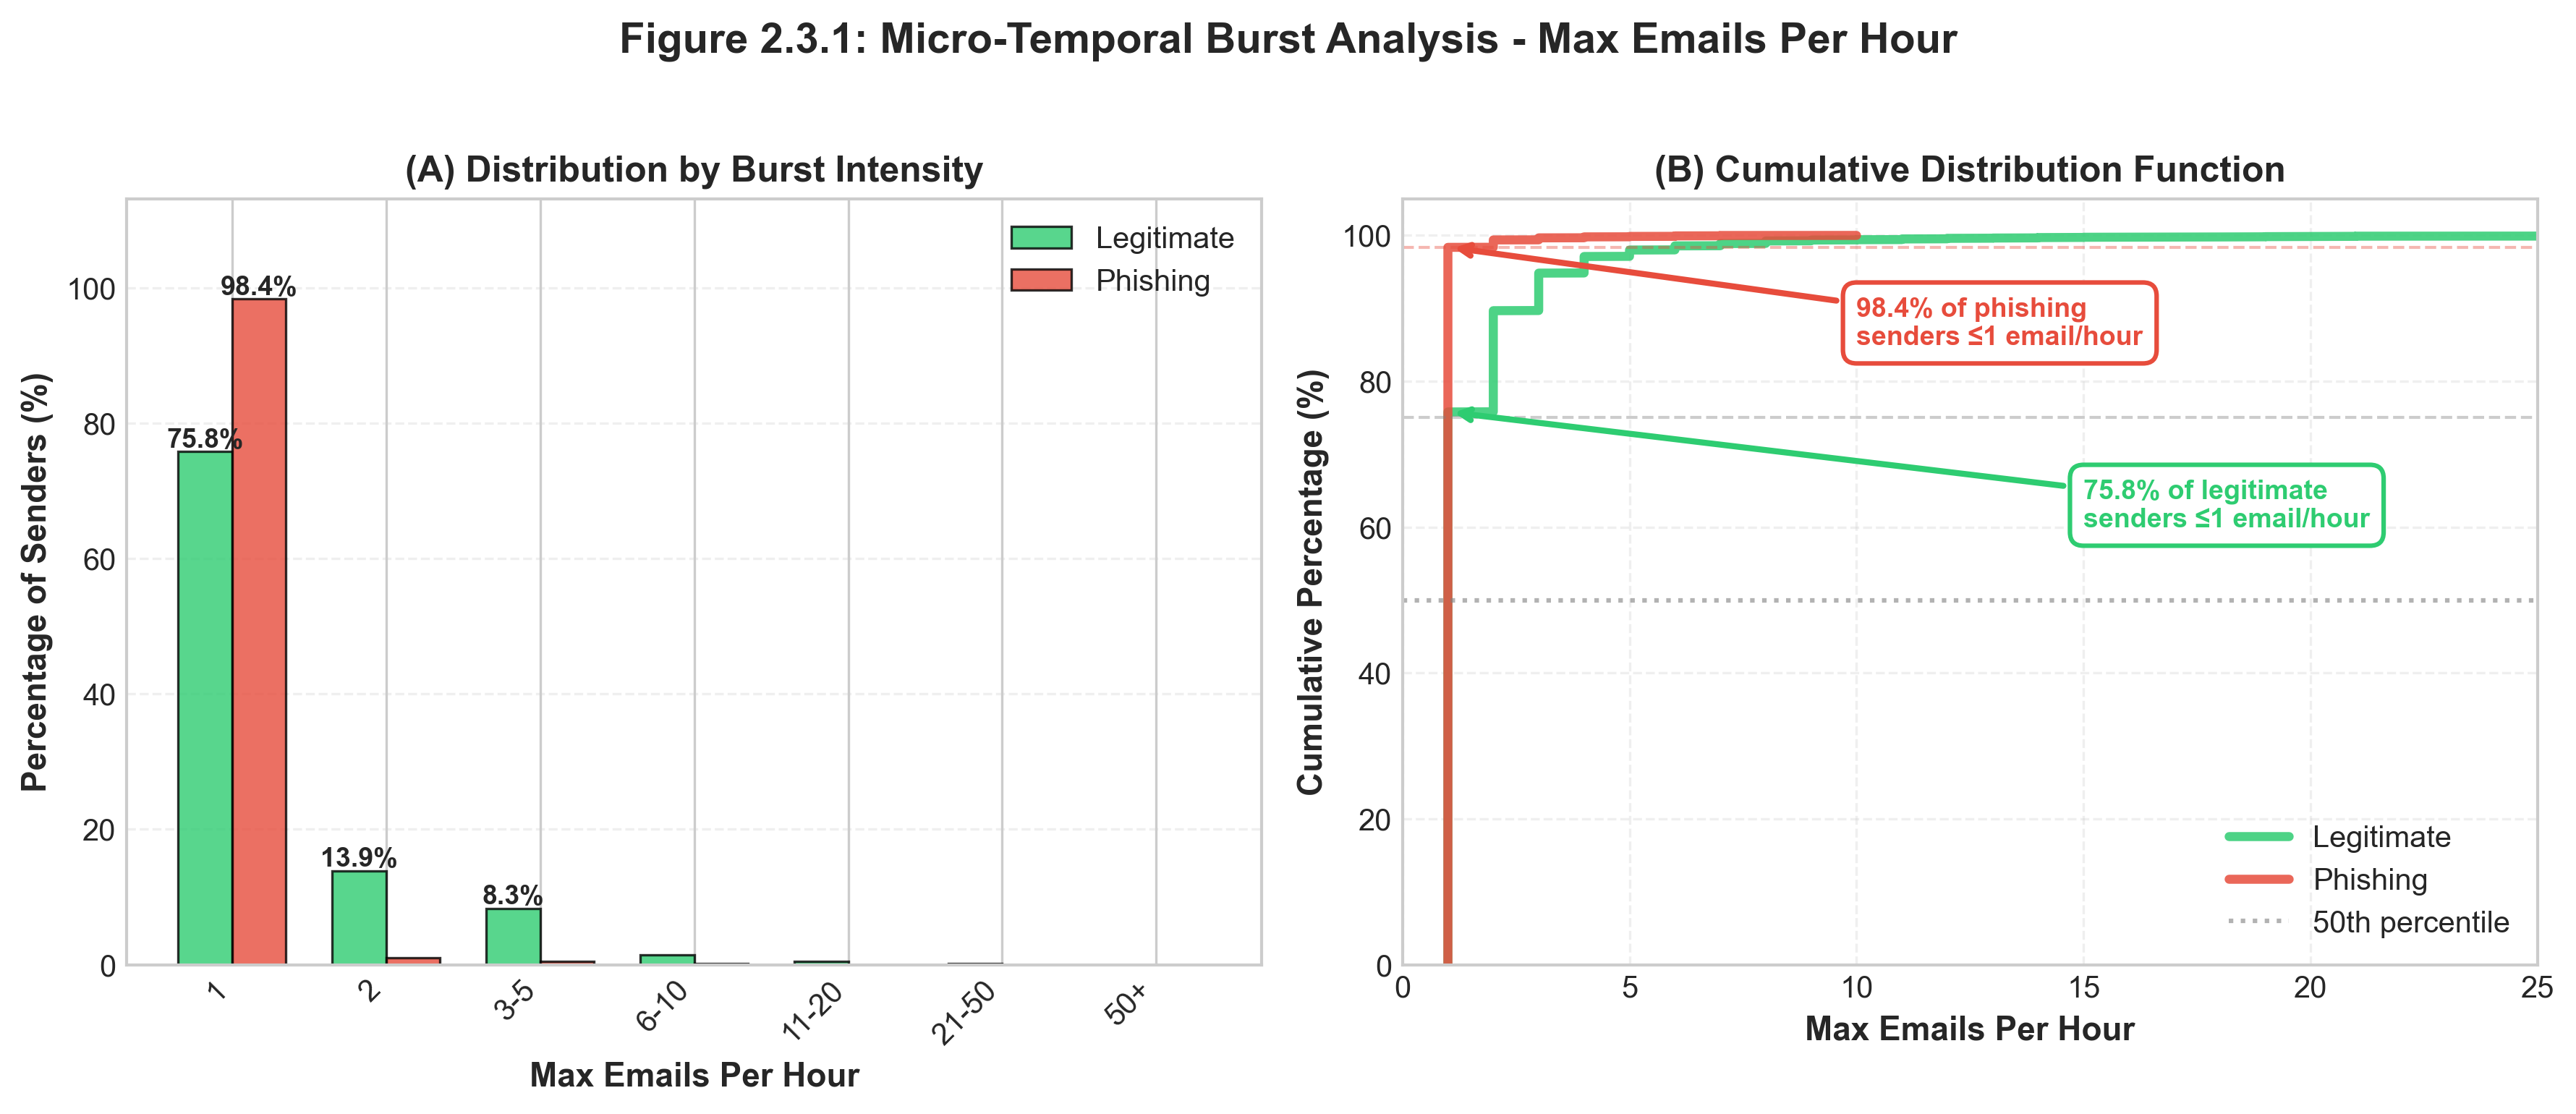

✅ Figure 2.3 saved: Shows phishers AVOID bursts (counterintuitive finding)


In [14]:
# FIGURE 2.3.1: Burst Detection Analysis (2-panel, publication quality)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Figure 2.3.1: Micro-Temporal Burst Analysis - Max Emails Per Hour', 
             fontsize=14, fontweight='bold', y=1.02)

# Color scheme
legit_color = '#2ecc71'  # Green
phish_color = '#e74c3c'   # Red

# Panel A: Distribution by bins (most interpretable)
bins = [0, 1, 2, 5, 10, 20, 50, float('inf')]
labels = ['1', '2', '3-5', '6-10', '11-20', '21-50', '50+']

legitimate_dist = pd.cut(legitimate_max, bins=bins, labels=labels).value_counts().sort_index()
phishing_dist = pd.cut(phishing_max, bins=bins, labels=labels).value_counts().sort_index()

# Convert to percentages
legitimate_pct = (legitimate_dist / len(legitimate_max)) * 100
phishing_pct = (phishing_dist / len(phishing_max)) * 100

x_pos = np.arange(len(labels))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, legitimate_pct, width, 
                    label='Legitimate', color=legit_color, alpha=0.8, 
                    edgecolor='black', linewidth=0.8)
bars2 = axes[0].bar(x_pos + width/2, phishing_pct, width, 
                    label='Phishing', color=phish_color, alpha=0.8, 
                    edgecolor='black', linewidth=0.8)

# Add percentage labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 3:  # Only label if bar is tall enough
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%', ha='center', va='bottom', 
                        fontsize=9, fontweight='bold')

axes[0].set_xlabel('Max Emails Per Hour', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Percentage of Senders (%)', fontsize=11, fontweight='bold')
axes[0].set_title('(A) Distribution by Burst Intensity', fontweight='bold', fontsize=12)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(labels, rotation=45, ha='right')
axes[0].legend(loc='upper right', framealpha=0.9)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, max(legitimate_pct.max(), phishing_pct.max()) * 1.15)

# Panel B: Cumulative Distribution (shows the gap clearly)
legitimate_sorted = np.sort(legitimate_max)
phishing_sorted = np.sort(phishing_max)
legitimate_cumulative = np.arange(1, len(legitimate_sorted) + 1) / len(legitimate_sorted) * 100
phishing_cumulative = np.arange(1, len(phishing_sorted) + 1) / len(phishing_sorted) * 100

axes[1].plot(legitimate_sorted, legitimate_cumulative, 
            label='Legitimate', linewidth=3, color=legit_color, alpha=0.85)
axes[1].plot(phishing_sorted, phishing_cumulative, 
            label='Phishing', linewidth=3, color=phish_color, alpha=0.85)

# Add reference lines and annotations
axes[1].axhline(y=50, color='gray', linestyle=':', linewidth=1.5, alpha=0.6, label='50th percentile')
axes[1].axhline(y=75, color='gray', linestyle='--', linewidth=1, alpha=0.4)
axes[1].axhline(y=98.4, color=phish_color, linestyle='--', linewidth=1, alpha=0.4)

# Annotate key finding
axes[1].annotate('98.4% of phishing\nsenders ≤1 email/hour', 
                xy=(1, 98.4), xytext=(10, 85),
                fontsize=9, fontweight='bold', color=phish_color,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=phish_color, linewidth=1.5),
                arrowprops=dict(arrowstyle='->', color=phish_color, lw=2))

axes[1].annotate('75.8% of legitimate\nsenders ≤1 email/hour', 
                xy=(1, 75.8), xytext=(15, 60),
                fontsize=9, fontweight='bold', color=legit_color,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=legit_color, linewidth=1.5),
                arrowprops=dict(arrowstyle='->', color=legit_color, lw=2))

axes[1].set_xlabel('Max Emails Per Hour', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
axes[1].set_title('(B) Cumulative Distribution Function', fontweight='bold', fontsize=12)
axes[1].set_xlim(0, 25)
axes[1].set_ylim(0, 105)
axes[1].legend(loc='lower right', framealpha=0.9)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figure_2_3_burst_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 2.3 saved: Shows phishers AVOID bursts (counterintuitive finding)")

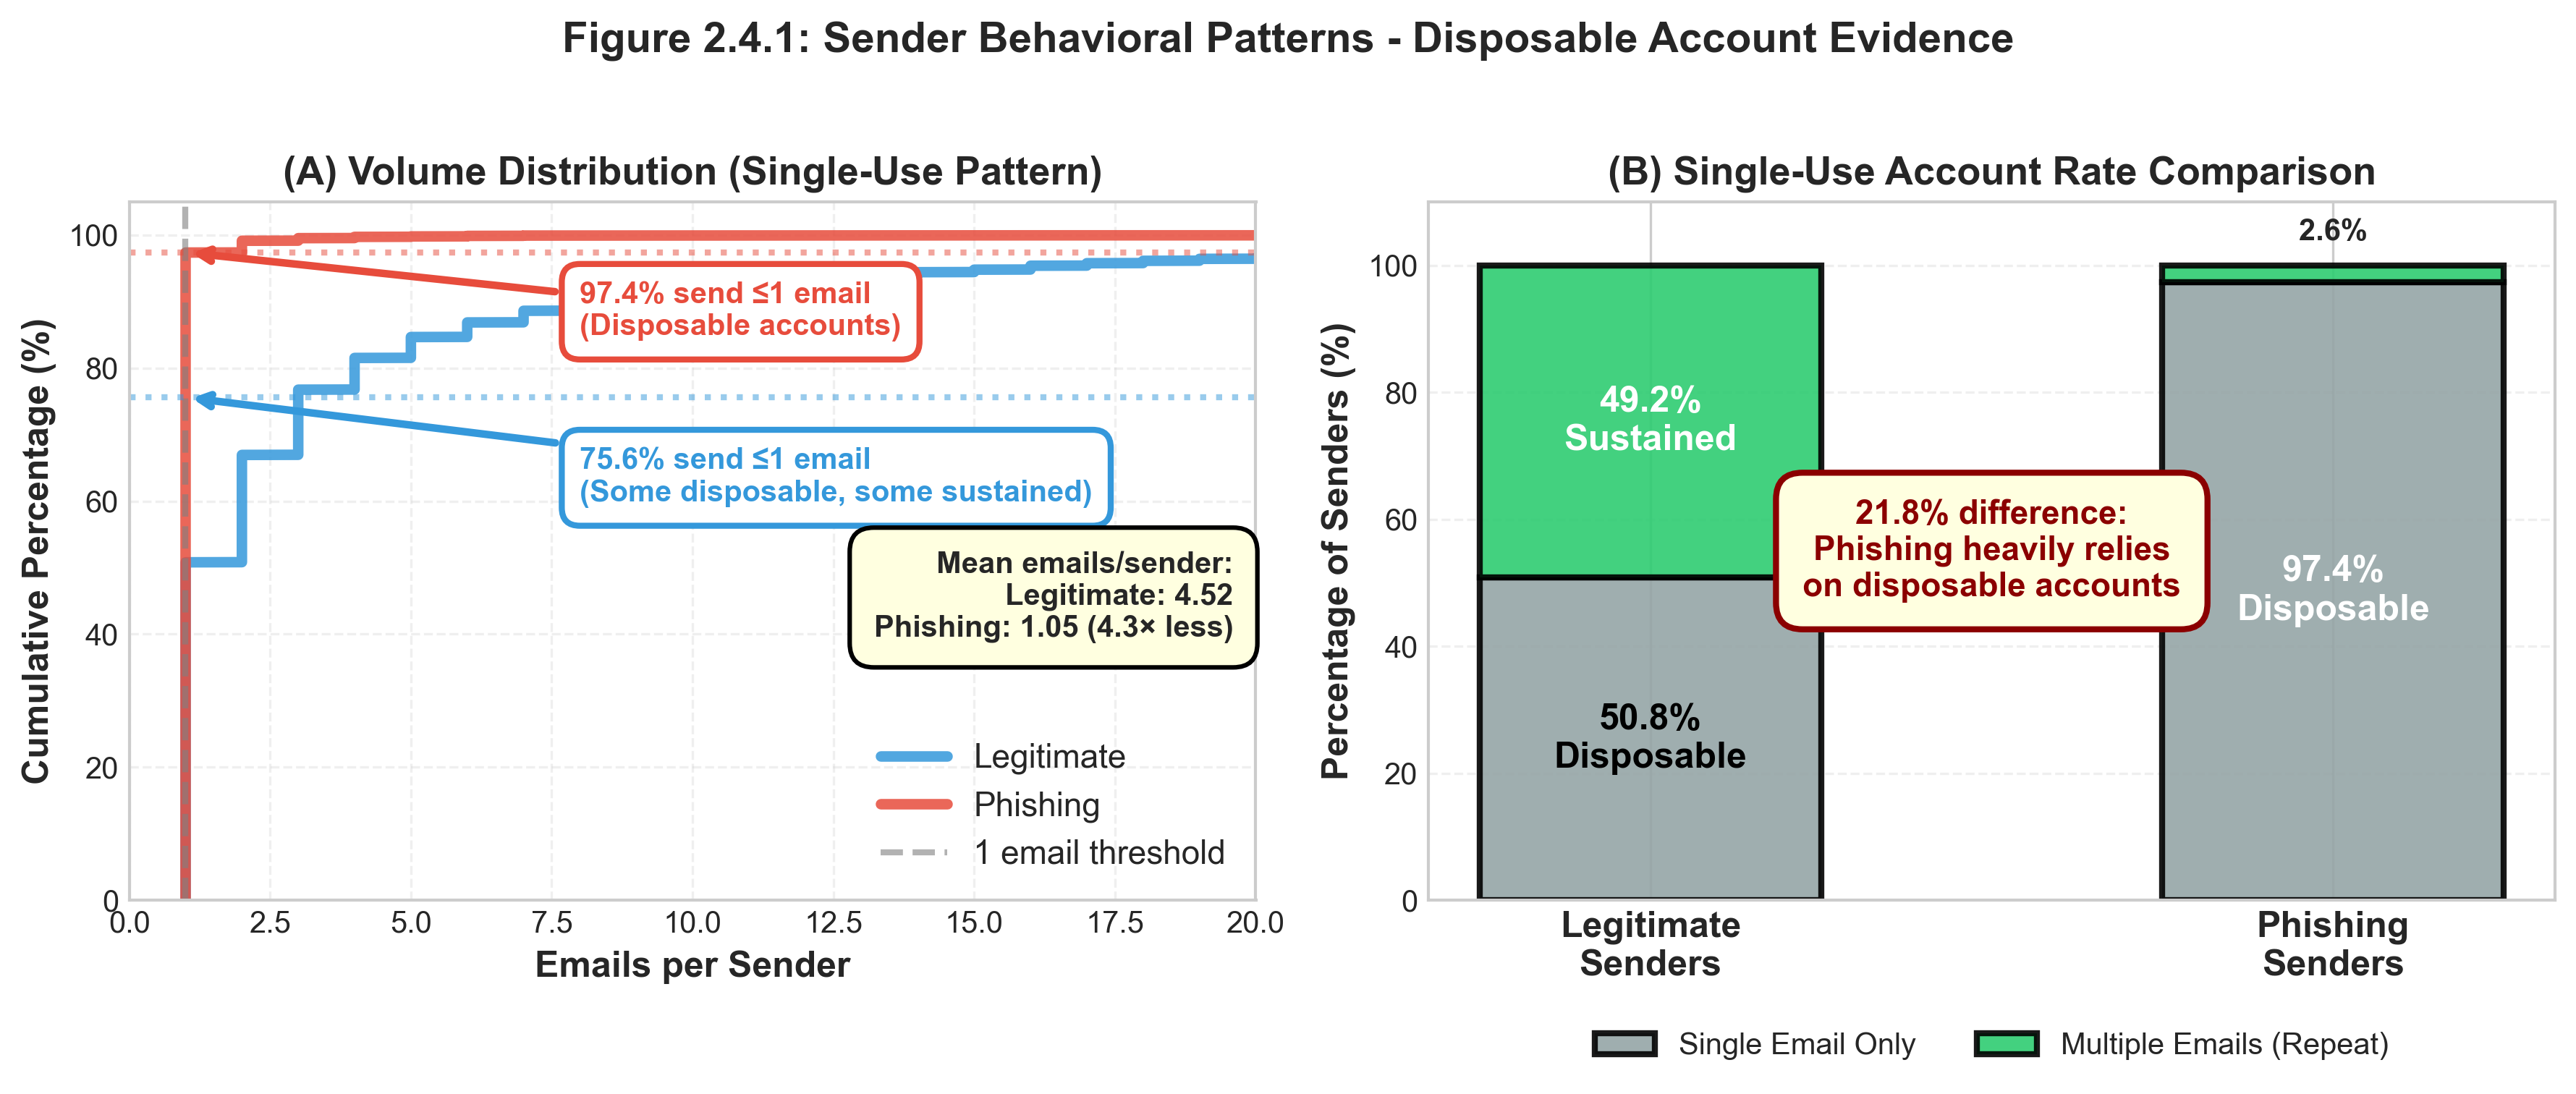

✅ Figure 2.4.1 saved: Shows volume + single-use pattern clearly


In [20]:
# FIGURE 2.4.1: Core H3 Evidence - Volume and Single-Use Pattern
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Figure 2.4.1: Sender Behavioral Patterns - Disposable Account Evidence', 
             fontsize=14, fontweight='bold', y=1.02)

# Color scheme
legit_color = '#3498db'  # Blue
phish_color = '#e74c3c'   # Red

# Panel A: Emails per Sender Distribution (CDF - shows the gap clearly)
legitimate_sorted = np.sort(legitimate_senders['total_emails'])
phishing_sorted = np.sort(phishing_senders['total_emails'])
legitimate_cumulative = np.arange(1, len(legitimate_sorted) + 1) / len(legitimate_sorted) * 100
phishing_cumulative = np.arange(1, len(phishing_sorted) + 1) / len(phishing_sorted) * 100

axes[0].plot(legitimate_sorted, legitimate_cumulative, 
            label='Legitimate', linewidth=3.5, color=legit_color, alpha=0.85)
axes[0].plot(phishing_sorted, phishing_cumulative, 
            label='Phishing', linewidth=3.5, color=phish_color, alpha=0.85)

# Add reference lines
axes[0].axvline(x=1, color='gray', linestyle='--', linewidth=2, alpha=0.6, label='1 email threshold')
axes[0].axhline(y=97.4, color=phish_color, linestyle=':', linewidth=2, alpha=0.5)
axes[0].axhline(y=75.6, color=legit_color, linestyle=':', linewidth=2, alpha=0.5)

# Key annotations
axes[0].annotate('97.4% send ≤1 email\n(Disposable accounts)', 
                xy=(1, 97.4), xytext=(8, 85),
                fontsize=10, fontweight='bold', color=phish_color,
                bbox=dict(boxstyle='round,pad=0.6', facecolor='white', 
                         edgecolor=phish_color, linewidth=2),
                arrowprops=dict(arrowstyle='->', color=phish_color, lw=2.5))

axes[0].annotate('75.6% send ≤1 email\n(Some disposable, some sustained)', 
                xy=(1, 75.6), xytext=(8, 60),
                fontsize=10, fontweight='bold', color=legit_color,
                bbox=dict(boxstyle='round,pad=0.6', facecolor='white', 
                         edgecolor=legit_color, linewidth=2),
                arrowprops=dict(arrowstyle='->', color=legit_color, lw=2.5))

axes[0].set_xlabel('Emails per Sender', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold')
axes[0].set_title('(A) Volume Distribution (Single-Use Pattern)', fontweight='bold', fontsize=13)
axes[0].set_xlim(0, 20)
axes[0].set_ylim(0, 105)
axes[0].legend(loc='lower right', framealpha=0.95, fontsize=11)
axes[0].grid(alpha=0.3, linestyle='--')

# Add summary statistics box
stats_text = f'Mean emails/sender:\nLegitimate: 4.52\nPhishing: 1.05 (4.3× less)'
axes[0].text(0.98, 0.50, stats_text,
            transform=axes[0].transAxes,
            fontsize=10, fontweight='bold',
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', 
                     edgecolor='black', linewidth=1.5))

# Panel B: Single-Use vs Repeat - BUT ONLY SHOW PHISHING (clearer message)
# Actually, let's show COMPARISON but with better labels

# Calculate the percentages correctly
legit_single_pct = (legitimate_senders['total_emails'] == 1).mean() * 100
legit_repeat_pct = (legitimate_senders['total_emails'] > 1).mean() * 100
phish_single_pct = (phishing_senders['total_emails'] == 1).mean() * 100
phish_repeat_pct = (phishing_senders['total_emails'] > 1).mean() * 100

categories = ['Legitimate\nSenders', 'Phishing\nSenders']
single_use = [legit_single_pct, phish_single_pct]
repeat_use = [legit_repeat_pct, phish_repeat_pct]

x_pos = np.arange(len(categories))
width = 0.5

# Create stacked bars
bars1 = axes[1].bar(x_pos, single_use, width,
                   label='Single Email Only', color='#95a5a6', alpha=0.9, 
                   edgecolor='black', linewidth=2)
bars2 = axes[1].bar(x_pos, repeat_use, width, bottom=single_use,
                   label='Multiple Emails (Repeat)', color='#2ecc71', alpha=0.9, 
                   edgecolor='black', linewidth=2)

# Add percentage labels
for i, (single, repeat) in enumerate(zip(single_use, repeat_use)):
    # Single use label
    axes[1].text(i, single/2, f'{single:.1f}%\nDisposable', 
                ha='center', va='center', fontweight='bold', fontsize=12, 
                color='white' if i == 1 else 'black')
    
    # Repeat use label (only if significant)
    if repeat > 8:
        axes[1].text(i, single + repeat/2, f'{repeat:.1f}%\nSustained', 
                    ha='center', va='center', fontweight='bold', fontsize=12, color='white')
    elif repeat > 0:
        axes[1].text(i, single + repeat + 3, f'{repeat:.1f}%', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(categories, fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage of Senders (%)', fontsize=12, fontweight='bold')
axes[1].set_title('(B) Single-Use Account Rate Comparison', fontweight='bold', fontsize=13)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
              ncol=2, framealpha=0.95, fontsize=10)
axes[1].set_ylim(0, 110)
axes[1].grid(alpha=0.3, linestyle='--', axis='y')

# Add key finding box
finding_text = '21.8% difference:\nPhishing heavily relies\non disposable accounts'
axes[1].text(0.5, 0.5, finding_text,
            transform=axes[1].transAxes,
            fontsize=11, fontweight='bold', color='darkred',
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', 
                     edgecolor='darkred', linewidth=2))

plt.tight_layout()
plt.savefig('figure_2_4_1_sender_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 2.4.1 saved: Shows volume + single-use pattern clearly")